**Author:** Beatrice Occhiena s314971. See [`LICENSE`](https://github.com/beatrice-occhiena/Computational_intelligence/blob/main/LICENSE) for details.
- institutional email: `S314971@studenti.polito.it`
- personal email: `beatrice.occhiena@live.it`
- github repository: [https://github.com/beatrice-occhiena/Computational_intelligence.git](https://github.com/beatrice-occhiena/Computational_intelligence.git)

**Resources:** These notes are the result of additional research and analysis of the lecture material presented by Professor Giovanni Squillero for the Computational Intelligence course during the academic year 2023-2024 @ Politecnico di Torino. They are intended to be my attempt to make a personal contribution and to rework the topics covered in the following resources.
- [https://github.com/squillero/computational-intelligence](https://github.com/squillero/computational-intelligence)
- Stuart Russel, Peter Norvig, *Artificial Intelligence: A Modern Approach* [3th edition]

# Halloween Challenge

The aim of this project is to solve the Set-covering problem trying different Single-state optimization algorithms.

Find the best solution with the **fewest calls to the fitness functions** for:
- `num_points = [100, 1_000, 5_000]`
- `num_sets = num_points`
- `density = [.3, .7]`


In [13]:
from itertools import product
from random import random, randint, shuffle, seed
import numpy as np
from scipy import sparse
import math
import matplotlib.pyplot as plt

## Problem instances
First of all, we need to define the `UNIVERSE_SIZE` and the `NUMBER_OF_SETS`. Each set is represented by a vector of binary values, where 1 means that the element is present in the set, 0 means that the element is not present in the set. We can control the `DENSITY` of the sets by adjusting the probability of 1s in the vector.

In [3]:
def make_set_covering_problem(num_points, num_sets, density):
    """Returns a sparse array where rows are sets and columns are the covered items"""
    seed(num_points*2654435761+num_sets+density)
    sets = sparse.lil_array((num_sets, num_points), dtype=bool)
    for s, p in product(range(num_sets), range(num_points)):
        if random() < density:
            sets[s, p] = True
    for p in range(num_points):
        sets[randint(0, num_sets-1), p] = True
    return np.array(sets.toarray())

In [4]:
num_points = [100, 1000, 5000]
num_sets = num_points
density = [.3, .7]

## Service functions
We need to define some service functions to:
- evaluate the quality of a solution
- mutate a solution
- check if a solution is feasible

In [5]:
def fitness(state, sets):
    """
    OB: Maximise the number of covered points, minimise the cost, minimise the overlap
    """
    cost = np.sum(state)
    selected_sets = sets[state == 1]
    overlap = np.sum(np.sum(selected_sets, axis=0) > 1)
    universe_coverage = np.sum(np.sum(selected_sets, axis=0) > 0)

    return universe_coverage, -cost, -overlap

def tweak(state):
    """
    OB: Flip a random bit
    """
    new_state = state.copy()
    i = randint(0, len(state)-1)
    new_state[i] = not state[i]
    return new_state

def is_valid(state, sets):
    """
    OB: All points are covered by at least one set
    """
    selected_sets = sets[state == 1]
    return np.sum(np.sum(selected_sets, axis=0) > 0) == len(state)

## Hill Climbing

### Random Mutation Hill Climbing
The first algorithm we are going to implement is the Random Mutation Hill Climbing. The algorithm is very simple: we start from a random solution and we try to improve it by randomly mutating it. If the new solution is better than the previous one, we keep it, otherwise we discard it.

In [6]:
def RMHC(initial_state, sets, max_iterations):
    """
    OB: Small, random, local changes to the state
    """
    state = initial_state
    best_fitness = fitness(state, sets)
    calling_fitness = 1

    # Keep looping until we reach the maximum number of iterations
    for i in range(max_iterations):
        new_state = tweak(state)
        new_fitness = fitness(new_state, sets)
        calling_fitness += 1
        if new_fitness > best_fitness:
            state = new_state
            best_fitness = new_fitness

        # Stop if we have a valid solution
        if is_valid(state, sets):
            break

    return state, best_fitness, calling_fitness

In [7]:

print("Random Mutation Hill Climbing")
print("OB: Small, random, local changes to the state")
print("----------------------------------------------")
for n, d in product(num_points, density):
  sets = make_set_covering_problem(n, n, d)
  initial_solution = np.zeros(n, dtype=bool)
  max_iterations = 1000
  best_solution, best_fitness, calling_fitness = RMHC(initial_solution, sets, max_iterations)
  print(f"n: {n}, d: {d}, best_fitness: {best_fitness}, calling_fitness: {calling_fitness}")

Random Mutation Hill Climbing
OB: Small, random, local changes to the state
----------------------------------------------
n: 100, d: 0.3, best_fitness: (100, -11, -93), calling_fitness: 12
n: 100, d: 0.7, best_fitness: (100, -4, -93), calling_fitness: 5
n: 1000, d: 0.3, best_fitness: (1000, -19, -989), calling_fitness: 23
n: 1000, d: 0.7, best_fitness: (1000, -6, -988), calling_fitness: 7
n: 5000, d: 0.3, best_fitness: (5000, -22, -4969), calling_fitness: 25
n: 5000, d: 0.7, best_fitness: (5000, -8, -4998), calling_fitness: 10


### Steepest Ascent Hill Climbing
We can make the algorithm more efficient by implementing the Steepest Ascent Hill Climbing. In this case, we try to improve the solution by creating n “tweaks” to a candidate solution
all at one time, and then possibly adopt the best one. In this way, we are sampling all around the original candidate solution, i.e. sampling the gradient and marching straight up it.

In [8]:
def SAHC(initial_state, sets, max_iterations, n_samples):
  """
  OB: Adopting the best neighbor at each iteration
  """
  state = initial_state
  best_fitness = fitness(state, sets)
  calling_fitness = 1

  # Keep looping until we reach the maximum number of iterations
  for i in range(max_iterations):

    # Evaluate all the neighbors of the current solution
    for sample in range(n_samples):
      new_state = tweak(state)
      new_fitness = fitness(new_state, sets)
      calling_fitness += 1
      if new_fitness > best_fitness:
        neighbor_best_state = new_state
        neighbor_best_fitness = new_fitness

    # If the best neighbor is better than the current solution, move to it
    if neighbor_best_fitness > best_fitness:
      state = neighbor_best_state
      best_fitness = neighbor_best_fitness

    # Stop if we have a valid solution
    if is_valid(state, sets):
      break

  return state, best_fitness, calling_fitness

In [9]:
print("Steepest Ascent Hill Climbing")
print("OB: Adopting the best neighbor at each iteration")
print("----------------------------------------------")
for n, d in product(num_points, density):
  sets = make_set_covering_problem(n, n, d)
  initial_solution = np.zeros(n, dtype=bool)
  max_iterations = 1000
  n_samples = 10
  best_solution, best_fitness, calling_fitness = SAHC(initial_solution, sets, max_iterations, n_samples)
  print(f"n: {n}, d: {d}, best_fitness: {best_fitness}, calling_fitness: {calling_fitness}")

Simulated Annealing Hill Climbing
OB: Adopting the best neighbor at each iteration
----------------------------------------------
n: 100, d: 0.3, best_fitness: (100, -13, -92), calling_fitness: 151
n: 100, d: 0.7, best_fitness: (100, -6, -98), calling_fitness: 61
n: 1000, d: 0.3, best_fitness: (1000, -17, -983), calling_fitness: 171
n: 1000, d: 0.7, best_fitness: (1000, -5, -969), calling_fitness: 51
n: 5000, d: 0.3, best_fitness: (5000, -23, -4987), calling_fitness: 231
n: 5000, d: 0.7, best_fitness: (5000, -8, -4996), calling_fitness: 81


## Simulated Annealing
Simulated Annealing is a probabilistic technique for approximating the global optimum of a given function. Specifically, it is a metaheuristic to approximate global optimization in a large search space for an optimization problem. It is often used when the search space is discrete (e.g., all tours that visit a given set of cities). For problems where finding an approximate global optimum is more important than finding a precise local optimum in a fixed amount of time, simulated annealing may be preferable to alternatives such as gradient ascent.

In [10]:
def SimulatedAnnealing(initial_state, sets, max_iterations, n_samples, initial_temperature, cooling_rate):

    state = initial_state
    best_fitness = fitness(state, sets)
    calling_fitness = 1
    temperature = initial_temperature

    for iteration in range(max_iterations):
        for sample in range(n_samples):
            new_state = tweak(state)
            new_fitness = fitness(new_state, sets)
            calling_fitness += 1

            # Calculate the difference between the new fitness and the old fitness
            # new fitness is a tuple of universe_coverage, -cost, -overlap
            new_f = new_fitness[0]
            old_f = best_fitness[0]
            fitness_difference = new_f - old_f

            # Accept worse solution with a certain probability
            if fitness_difference > 0 or np.random.rand() < math.exp(fitness_difference / temperature):
                state = new_state
                best_fitness = new_fitness

        # Cool down the temperature
        temperature *= cooling_rate

        if is_valid(state, sets):
            break

    return state, best_fitness, calling_fitness

In [11]:
print("Simulated Annealing")
print("OB: Accept worse solution with a certain probability")
print("----------------------------------------------")
for n, d in product(num_points, density):
  sets = make_set_covering_problem(n, n, d)
  initial_solution = np.zeros(n, dtype=bool)
  max_iterations = 1000
  n_samples = 10
  initial_temperature = 1
  cooling_rate = 0.95
  best_solution, best_fitness, calling_fitness = SimulatedAnnealing(initial_solution, sets, max_iterations, n_samples, initial_temperature, cooling_rate)
  print(f"n: {n}, d: {d}, best_fitness: {best_fitness}, calling_fitness: {calling_fitness}")

Simulated Annealing
OB: Accept worse solution with a certain probability
----------------------------------------------
n: 100, d: 0.3, best_fitness: (100, -16, -99), calling_fitness: 21
n: 100, d: 0.7, best_fitness: (100, -9, -100), calling_fitness: 11
n: 1000, d: 0.3, best_fitness: (1000, -28, -999), calling_fitness: 31
n: 1000, d: 0.7, best_fitness: (1000, -10, -1000), calling_fitness: 11
n: 5000, d: 0.3, best_fitness: (5000, -30, -4996), calling_fitness: 31
n: 5000, d: 0.7, best_fitness: (5000, -10, -4999), calling_fitness: 11


## Fitness Landscape Analysis

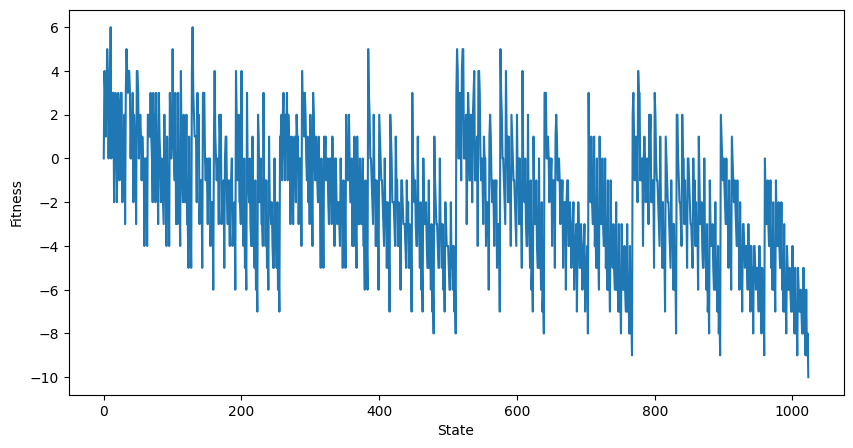

In [22]:
num_points = 10
density = 0.3
sets = make_set_covering_problem(num_points, num_points, 0.3)
initial_solution = np.zeros(num_points, dtype=bool)

num_states = 2**num_points
state_space = np.array([list(np.binary_repr(i, width=num_points)) for i in range(num_states)], dtype=int)
fitness_values = np.array([fitness(state, sets) for state in state_space])
fitness_function = np.array([fitness(state, sets)[0]+fitness(state, sets)[1]+fitness(state, sets)[2] for state in state_space])

plt.figure(figsize=(10, 5))
plt.plot(fitness_function)
plt.xlabel("State")
plt.ylabel("Fitness")
plt.show()
